# Dokumentasi: Deteksi DINI PPOK (COPD) dengan KNN

**Tujuan:** Proyek ini bertujuan untuk membangun model *Machine Learning* menggunakan algoritma K-Nearest Neighbors (KNN) untuk memprediksi risiko penyakit PPOK (COPD) berdasarkan data mortalitas yang telah di-augmentasi.

**Alur Kerja:**
1.  **Setup:** Impor *library* yang diperlukan.
2.  **Load Data:** Memuat dataset.
3.  **Data Cleaning:** Menangani nilai yang hilang (*missing values*) dan data duplikat.
4.  **Exploratory Data Analysis (EDA):** Menganalisis data, melihat distribusi, dan mendeteksi *outliers*.
5.  **Feature Engineering:** Membuat fitur baru untuk meningkatkan performa model.
6.  **Preprocessing:** Menyiapkan data untuk model (Encoding, Split, Resampling, Scaling).
7.  **Modeling & Tuning:** Melatih model KNN dan mencari *hyperparameter* terbaik dengan `GridSearchCV`.
8.  **Evaluation:** Mengevaluasi performa model terbaik pada data uji.
9.  **Save Model:** Menyimpan model, *scaler*, dan *encoder* ke dalam file `.pkl`.
10. **Sample Prediction:** Menjalankan contoh prediksi pada data baru.

## 1. Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTETomek

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

## 2. Load Dataset

In [19]:
df = pd.read_csv('ppok.csv')

df.head()

,age,BMI,heart rate,SP O2,gendera,Predicted_Activity_Level,Predicted_Smoking_Status,COPD
0,17,23.1,118,94,0,High,No,0
1,17,19.0,86,81,1,Low,No,1
2,17,29.5,80,99,0,Low,Yes,0
3,17,19.5,87,86,1,Medium,Yes,1
4,17,21.5,104,82,0,Medium,Yes,0


## 3. Data Cleaning


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1760 non-null   int64  
 1   BMI                       1760 non-null   float64
 2   heart rate                1760 non-null   int64  
 3   SP O2                     1760 non-null   int64  
 4   gendera                   1760 non-null   int64  
 5   Predicted_Activity_Level  1760 non-null   object 
 6   Predicted_Smoking_Status  1760 non-null   object 
 7   COPD                      1760 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 110.1+ KB


In [21]:
print("Jumlah nilai null sebelum dibersihkan:")
print(df.isnull().sum())

df.dropna(inplace=True)

print("\nJumlah nilai null setelah dibersihkan:")
print(df.isnull().sum().sum())

Jumlah nilai null sebelum dibersihkan:
age                         0
BMI                         0
heart rate                  0
SP O2                       0
gendera                     0
Predicted_Activity_Level    0
Predicted_Smoking_Status    0
COPD                        0
dtype: int64

Jumlah nilai null setelah dibersihkan:
0


In [22]:
print(f"Jumlah data duplikat sebelum dibersihkan: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(f"Jumlah data duplikat setelah dibersihkan: {df.duplicated().sum()}")

print(f"\nBentuk data akhir setelah cleaning: {df.shape}")

Jumlah data duplikat sebelum dibersihkan: 0
Jumlah data duplikat setelah dibersihkan: 0

Bentuk data akhir setelah cleaning: (1760, 8)


## 4. Exploratory Data Analysis (EDA)


### 4.1. Statistik Deskriptif

Melihat ringkasan statistik untuk fitur numerikal.

In [23]:
df.describe()

,age,BMI,heart rate,SP O2,gendera,COPD
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,38.500000,25.308523,98.914205,89.456818,0.500000,0.500000
std,12.702034,5.605631,11.425365,5.719158,0.500142,0.500142
min,17.000000,16.000000,80.000000,80.000000,0.000000,0.000000
25%,27.750000,20.400000,89.000000,85.000000,0.000000,0.000000
50%,38.500000,25.300000,99.000000,90.000000,0.500000,0.500000
75%,49.250000,30.300000,108.000000,94.000000,1.000000,1.000000
max,60.000000,35.000000,119.000000,99.000000,1.000000,1.000000


### 4.2. Distribusi Kelas Target (COPD)

Sangat penting untuk memeriksa apakah kelas target kita seimbang (*balanced*) atau tidak (*imbalanced*).

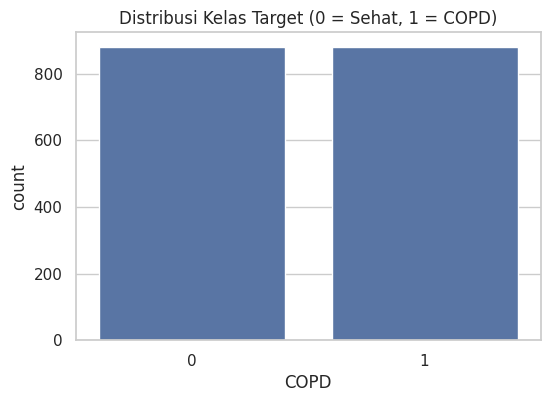

COPD
0    0.5
1    0.5
Name: proportion, dtype: float64


In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='COPD', data=df)
plt.title('Distribusi Kelas Target (0 = Sehat, 1 = COPD)')
plt.show()

print(df['COPD'].value_counts(normalize=True))

**Analisis:** Dataset ini terlihat *imbalanced* (tidak seimbang), di mana jumlah satu kelas jauh lebih sedikit daripada kelas lainnya. Ini memvalidasi keputusan untuk menggunakan teknik *resampling* seperti `SMOTETomek` nanti.

### 4.3. Distribusi Fitur Numerikal & Cek Outliers

Menggunakan **Box Plot** untuk melihat sebaran data dan mendeteksi adanya *outliers*.

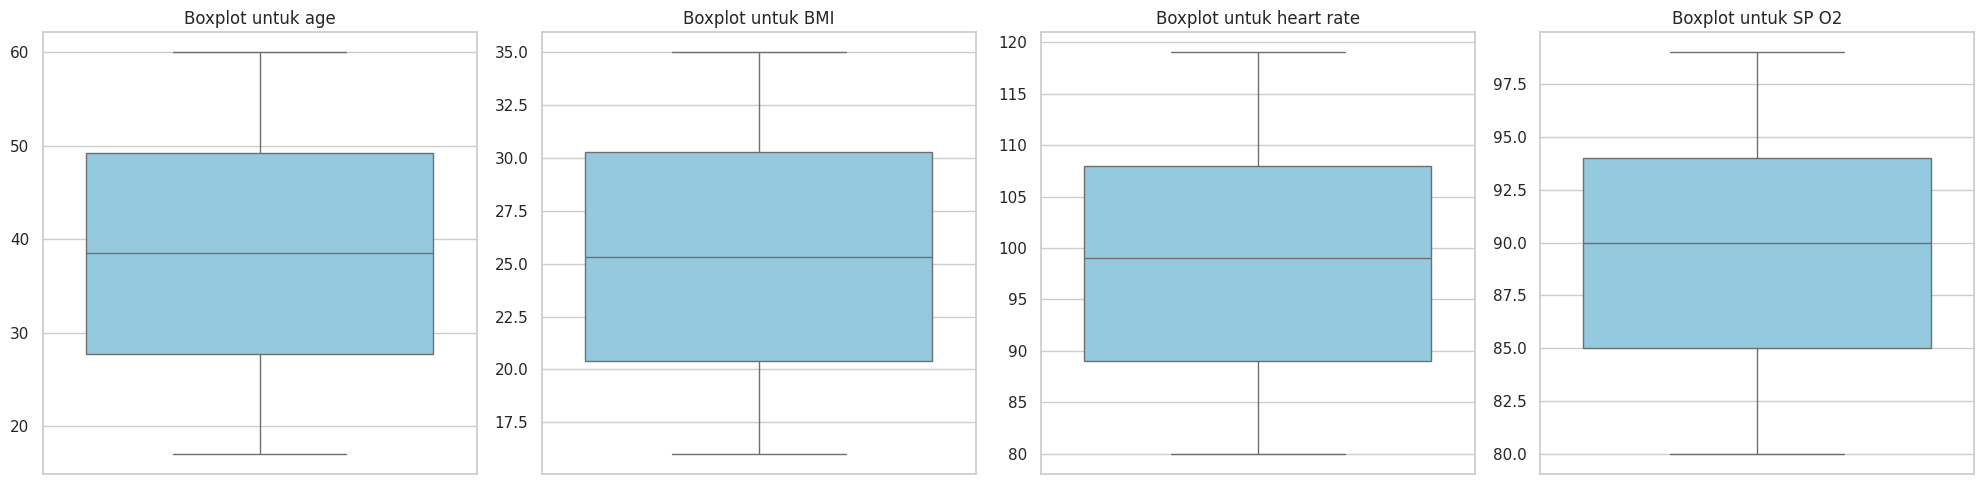

In [25]:
numerical_features = ['age', 'BMI', 'heart rate', 'SP O2']

plt.figure(figsize=(20, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, len(numerical_features), i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot untuk {col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

**Analisis:**
* Boxplot di atas menunjukkan adanya beberapa *outliers* (titik-titik di luar plot) pada beberapa fitur.
* Untuk model berbasis jarak seperti KNN, *outliers* bisa berpengaruh. Namun, penghapusan *outliers* harus dilakukan dengan hati-hati.
* Dalam kasus ini, kita akan melanjutkan tanpa menghapus *outliers* terlebih dahulu, namun kita akan menggunakan `MinMaxScaler` yang dapat membantu mengurangi dampak *outliers* dibandingkan `StandardScaler`.

### 4.4. Distribusi Fitur Kategorikal

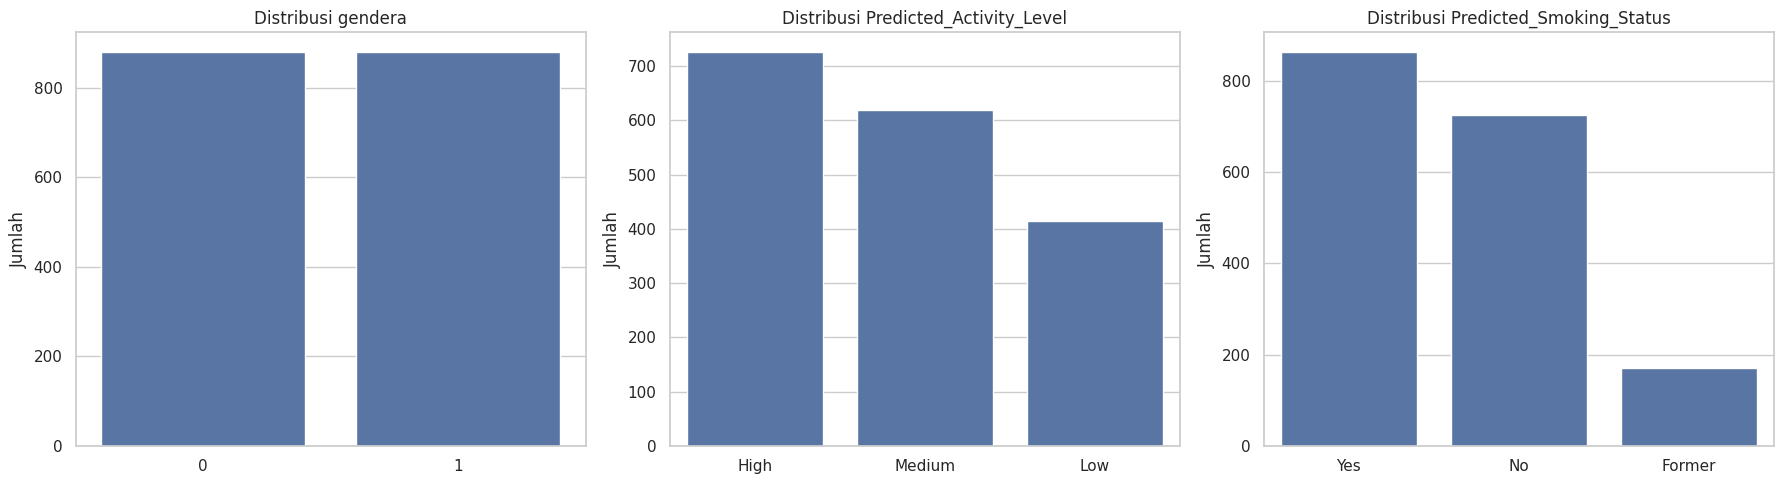

In [26]:
categorical_features_for_plot = ['gendera', 'Predicted_Activity_Level', 'Predicted_Smoking_Status']

plt.figure(figsize=(18, 5))
for i, col in enumerate(categorical_features_for_plot):
    if col in df.columns:
        plt.subplot(1, len(categorical_features_for_plot), i+1)
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Distribusi {col}')
        plt.xlabel('')
        plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

## 5. Feature Engineering

Tujuannya adalah untuk memberikan informasi tambahan kepada model yang mungkin tidak dapat ditangkap dari fitur aslinya secara individual.

In [27]:
# Daftar fitur awal
features = ['age', 'BMI', 'heart rate', 'SP O2', 'gendera',
            'Predicted_Activity_Level', 'Predicted_Smoking_Status']
target = 'COPD'

# Buat fitur turunan
df['HR_SPO2_ratio'] = df['heart rate'] / df['SP O2']
df['BMI_age_ratio'] = df['BMI'] / df['age']
df['HRxBMI'] = df['heart rate'] * df['BMI']

# Tambahkan fitur baru ke daftar 'features'
features.extend(['HR_SPO2_ratio', 'BMI_age_ratio', 'HRxBMI'])

print("Fitur baru berhasil dibuat.")
print(f"Total fitur yang akan digunakan: {len(features)}")
print(features)

Fitur baru berhasil dibuat.
Total fitur yang akan digunakan: 10
['age', 'BMI', 'heart rate', 'SP O2', 'gendera', 'Predicted_Activity_Level', 'Predicted_Smoking_Status', 'HR_SPO2_ratio', 'BMI_age_ratio', 'HRxBMI']


## 6. Preprocessing Data

Menyiapkan data agar siap dimasukkan ke dalam model.

### 6.1. Encoding Fitur Kategorikal (PERBAIKAN)

Model *machine learning* hanya mengerti angka. Kita ubah fitur kategorikal (seperti 'Yes'/'No') menjadi angka (0/1) menggunakan `LabelEncoder`.

**PENTING:** Kita definisikan daftarnya secara eksplisit untuk menghindari `ValueError` jika `select_dtypes` gagal.

In [28]:
# Definisikan kolom kategorikal secara EKSPLISIT
# 'gendera' sepertinya sudah numerik (1), jadi tidak perlu dimasukkan di sini.
categorical_cols = ['Predicted_Activity_Level', 'Predicted_Smoking_Status']

le_dict = {} # Dictionary untuk menyimpan encoder
print("--- Melakukan Encoding ---")

for col in categorical_cols:
    if col in df.columns: # Pastikan kolom ada di DataFrame
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
        print(f"Kolom '{col}' di-encode. Kelas: {le.classes_}")
    else:
        print(f"Peringatan: Kolom '{col}' tidak ditemukan di DataFrame.")

# Catatan: 'gendera' diasumsikan sudah numerik (0/1) berdasarkan skrip asli.

--- Melakukan Encoding ---
Kolom 'Predicted_Activity_Level' di-encode. Kelas: ['High' 'Low' 'Medium']
Kolom 'Predicted_Smoking_Status' di-encode. Kelas: ['Former' 'No' 'Yes']


### 6.2. Definisi X (Fitur) dan y (Target)

Setelah encoding, kita bisa memisahkan fitur (X) dan target (y).

In [29]:
X = df[features]
y = df[target]

print(f"Bentuk X (fitur): {X.shape}")
print(f"Bentuk y (target): {y.shape}")

Bentuk X (fitur): (1760, 10)
Bentuk y (target): (1760,)


### 6.3. Split Data (Train & Test)

Kita membagi data menjadi data latih (*train*) dan data uji (*test*). Kita menggunakan `stratify=y` untuk memastikan proporsi kelas target (COPD vs Sehat) di data latih dan data uji tetap sama.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% data untuk testing
    random_state=42,  # Agar hasil split konsisten
    stratify=y        # Menjaga proporsi kelas y
)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")

Ukuran X_train: (1408, 10)
Ukuran X_test: (352, 10)


### 6.4. Resampling (SMOTETomek)

Berdasarkan EDA, data kita *imbalanced*. Kita gunakan `SMOTETomek` (kombinasi *Oversampling* SMOTE dan *Undersampling* Tomek Links) untuk menyeimbangkan kelas minoritas pada **data latih saja**.

**PENTING:** Resampling hanya dilakukan pada `X_train` dan `y_train`.

In [31]:
smt = SMOTETomek(random_state=42)
print("Distribusi kelas y_train SEBELUM resampling:")
print(y_train.value_counts())

X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print("\nDistribusi kelas y_train SETELAH resampling (SMOTETomek):")
print(y_train_res.value_counts())

Distribusi kelas y_train SEBELUM resampling:
COPD
1    704
0    704
Name: count, dtype: int64

Distribusi kelas y_train SETELAH resampling (SMOTETomek):
COPD
1    511
0    511
Name: count, dtype: int64


### 6.5. Normalisasi Data (Scaling)

Algoritma KNN bekerja berdasarkan perhitungan jarak. Kita gunakan `MinMaxScaler` untuk mengubah semua nilai fitur ke rentang yang sama (0 sampai 1).

* `fit_transform` pada data latih (yang sudah di-resampling).
* `transform` pada data uji (menggunakan skala yang dipelajari dari data latih).

In [32]:
scaler = MinMaxScaler()

# Fit dan transform data latih
X_train_scaled = scaler.fit_transform(X_train_res)

# Transform data uji
X_test_scaled = scaler.transform(X_test)

print("Data berhasil di-scaling.")

Data berhasil di-scaling.


## 7. Pemodelan & Hyperparameter Tuning (GridSearchCV)

<encari parameter terbaik untuk model KNN kita. Kita gunakan `GridSearchCV` untuk menguji berbagai kombinasi parameter secara sistematis menggunakan *Cross-Validation*.

In [33]:
print("--- Memulai Hyperparameter Tuning (GridSearchCV) ---")

# Tentukan parameter grid untuk diuji
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15], # Uji beberapa nilai K
    'weights': ['uniform', 'distance'],      # Uji kedua metode weighting
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Uji 3 metrik jarak
}

# Inisialisasi GridSearchCV
# cv=5 adalah 5-fold cross-validation
# n_jobs=-1 menggunakan semua core CPU untuk mempercepat proses
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Gunakan semua core CPU
    verbose=1  # Tampilkan progress
)

# Lakukan fitting pada data training yang sudah di-resample dan di-scaled
grid_search.fit(X_train_scaled, y_train_res)

# Dapatkan model terbaik
knn = grid_search.best_estimator_

print("\n--- Tuning Selesai ---")
print(f"Parameter terbaik ditemukan: {grid_search.best_params_}")
print(f"Akurasi CV terbaik dari tuning: {grid_search.best_score_:.4f}")

--- Memulai Hyperparameter Tuning (GridSearchCV) ---
Fitting 5 folds for each of 42 candidates, totalling 210 fits

--- Tuning Selesai ---
Parameter terbaik ditemukan: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Akurasi CV terbaik dari tuning: 0.7681


## 8. Evaluasi Model

Menggunakan model `knn` (model terbaik dari `GridSearchCV`) untuk membuat prediksi pada `X_test_scaled` (data uji yang bersih dan belum pernah dilihat) dan mengevaluasi performanya.

In [34]:
# Lakukan prediksi pada data uji
y_pred = knn.predict(X_test_scaled)

print("--- HASIL EVALUASI (Model Terbaik pada Test Set) ---")
print(f"Akurasi pada Test Set: {accuracy_score(y_test, y_pred):.4f}")

# Ambil skor CV dari hasil tuning
cv_score = grid_search.best_score_
print(f"Rata-rata akurasi CV (dari GridSearch cv=5): {cv_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

--- HASIL EVALUASI (Model Terbaik pada Test Set) ---
Akurasi pada Test Set: 0.7557
Rata-rata akurasi CV (dari GridSearch cv=5): 0.7681

Classification Report:
              precision    recall  f1-score   support

           0      0.727     0.818     0.770       176
           1      0.792     0.693     0.739       176

    accuracy                          0.756       352
   macro avg      0.760     0.756     0.755       352
weighted avg      0.760     0.756     0.755       352



### 8.1. Visualisasi Confusion Matrix

Confusion matrix membantu kita melihat secara detail di mana model melakukan kesalahan. (Misal: Berapa banyak pasien Sehat yang diprediksi COPD, dan sebaliknya).

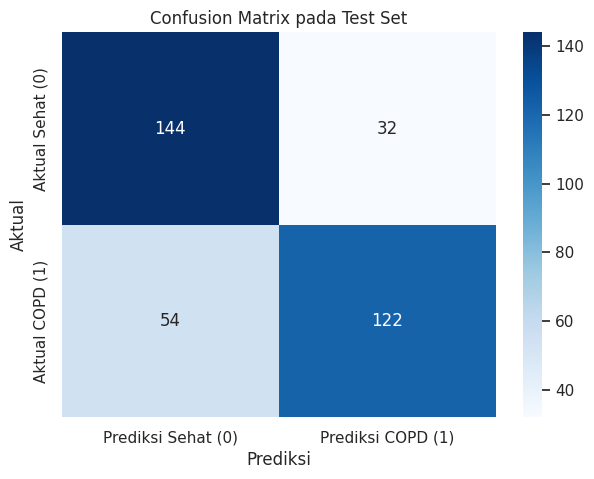

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi Sehat (0)', 'Prediksi COPD (1)'],
            yticklabels=['Aktual Sehat (0)', 'Aktual COPD (1)'])
plt.title('Confusion Matrix pada Test Set')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

--- DISTRIBUSI PREDIKSI RISIKO BERDASARKAN LABEL AKTUAL ---


Prediksi Risiko,Rendah,Sedang,Tinggi
Aktual,,,
COPD,40,32,104
Sehat,103,66,7


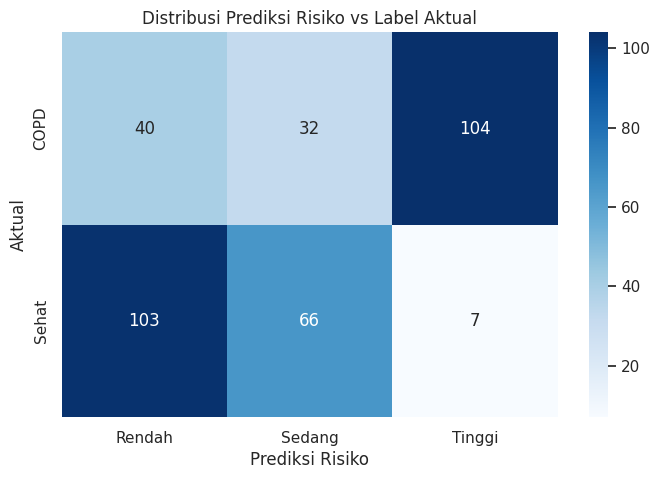


--- JUMLAH PREDIKSI UNTUK SETIAP KATEGORI RISIKO ---
Prediksi_Risiko
Rendah    143
Tinggi    111
Sedang     98
Name: count, dtype: int64


In [38]:
y_pred_proba = knn.predict_proba(X_test_scaled)

low_risk_threshold = 0.33
medium_risk_threshold = 0.66

predicted_risk_labels = []
for prob in y_pred_proba:
    prob_copd = prob[1]
    if prob_copd < low_risk_threshold:
        predicted_risk_labels.append("Rendah")
    elif prob_copd < medium_risk_threshold:
        predicted_risk_labels.append("Sedang")
    else:
        predicted_risk_labels.append("Tinggi")

results_df = pd.DataFrame({
    'Aktual': y_test,
    'Prediksi_Risiko': predicted_risk_labels
})

results_df['Aktual_Label'] = results_df['Aktual'].map({0: 'Sehat', 1: 'COPD'})

risk_confusion_matrix = pd.crosstab(results_df['Aktual_Label'], results_df['Prediksi_Risiko'],
                                    rownames=['Aktual'], colnames=['Prediksi Risiko'])

print("--- DISTRIBUSI PREDIKSI RISIKO BERDASARKAN LABEL AKTUAL ---")
display(risk_confusion_matrix)

plt.figure(figsize=(8, 5))
sns.heatmap(risk_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Distribusi Prediksi Risiko vs Label Aktual')
plt.xlabel('Prediksi Risiko')
plt.ylabel('Aktual')
plt.show()

print("\n--- JUMLAH PREDIKSI UNTUK SETIAP KATEGORI RISIKO ---")
print(results_df['Prediksi_Risiko'].value_counts())

## 9. Simpan Model (Pickling)

Kita menyimpan semua komponen penting (model `knn`, `scaler`, dan `le_dict`) ke dalam satu file `.pkl` menggunakan `pickle`. Ini memungkinkan kita untuk memuat dan menggunakan model ini di lain waktu tanpa harus melatih ulang.

In [ ]:
# Siapkan dictionary untuk disimpan
final_model = {
    'model': knn, # Menyimpan model terbaik
    'scaler': scaler, # Menyimpan scaler
    'encoders': le_dict, # Menyimpan dictionary encoder
    'selected_features': features, # Menyimpan daftar fitur yang digunakan
    'accuracy': accuracy_score(y_test, y_pred),
    'cv_accuracy': cv_score,
    'best_params': grid_search.best_params_ # Simpan parameter terbaik
}

# Simpan ke file
filename = 'knn_copd_final_tuned.pkl'
with open(filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"\n✅ Model (tuned), scaler, dan encoder berhasil disimpan ke '{filename}'")


✅ Model (tuned), scaler, dan encoder berhasil disimpan ke 'knn_copd_final_tuned.pkl'


## 10. Contoh Prediksi pada Data Baru

Ini adalah simulasi bagaimana model yang disimpan akan digunakan untuk memprediksi data baru. Kita harus menerapkan langkah *preprocessing* yang **sama persis** seperti yang dilakukan pada data latih (Feature Engineering, Encoding, Scaling).

**Catatan:** Bagian ini akan otomatis berfungsi dengan benar karena menggunakan variabel `categorical_cols`

In [ ]:
sample_data = {
    'age': 55,
    'BMI': 27.1,
    'heart rate': 90,
    'SP O2': 93,
    'gendera': 1,
    'Predicted_Activity_Level': 'High',
    'Predicted_Smoking_Status': 'Yes'
}
sample = pd.DataFrame([sample_data])

print("Data sample awal:")
display(sample)

sample['HR_SPO2_ratio'] = sample['heart rate'] / sample['SP O2']
sample['BMI_age_ratio'] = sample['BMI'] / sample['age']
sample['HRxBMI'] = sample['heart rate'] * sample['BMI']

for col in categorical_cols:
    if col in sample.columns and col in le_dict:
        le = le_dict[col]
        sample[col] = sample[col].map(
            lambda s: le.transform([s])[0] if s in le.classes_ else -1
        )

print("\nData sample setelah engineering & encoding:")
display(sample[features])

sample_features = sample[features]
sample_scaled = scaler.transform(sample_features)

pred = knn.predict(sample_scaled)[0]
pred_proba = knn.predict_proba(sample_scaled)[0]

print("--- HASIL PREDIKSI DATA BARU ---")
print(f"Prediksi: {pred} ({'Terindikasi COPD' if pred==1 else 'Sehat'})" )
print(f"Probabilitas: [Kelas 0: {pred_proba[0]:.2%}, Kelas 1: {pred_proba[1]:.2%}]" )

Data sample awal:


,age,BMI,heart rate,SP O2,gendera,Predicted_Activity_Level,Predicted_Smoking_Status
0,55,27.1,90,93,1,High,Yes



Data sample setelah engineering & encoding:


,age,BMI,heart rate,SP O2,gendera,Predicted_Activity_Level,Predicted_Smoking_Status,HR_SPO2_ratio,BMI_age_ratio,HRxBMI
0,55,27.1,90,93,1,0,2,0.967742,0.492727,2439.0


--- HASIL PREDIKSI DATA BARU ---
Prediksi: 1 (Terindikasi COPD)
Probabilitas: [Kelas 0: 0.00%, Kelas 1: 100.00%]
